# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE
# from PCAfold         import PCA          as PCAA


import romnet                            as rmnt


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_500Cases_CH4_/')

path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_500Cases_CH4_PCA/DeepONet/Run_3/')

FigDir           = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet/')


DataType         = 'train'
CasesVec         = range(0,500,100)
# DataType         = 'test'
# CasesVec         = range(10) #[1,0,2]



NSamples         = 1

NVarsRed         = 20

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/DeepONet/../../../../../../ROMNet/0DReact_Isobaric_500Cases_CH4_PCA/DeepONet/Run_3/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.architecture, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x1649fc610>, <keras.layers.core.dense.Dense object at 0x164e7f9a0>, <keras.layers.core.dense.Dense object at 0x164ed1a60>, <keras.layers.core.dense.Dense object at 0x164e7ffa0>, <keras.layers.core.dense.Dense object at 0x164e7f640>, <keras.layers.core.dense.Dense object at 0x164e

## Evaluating DeepONet on Test Data

### Loading Simulations Info

In [5]:
input_vars_        = pd.read_csv(DataDir+'/'+str(NVarsRed)+'PC/CleanVars_ToRed.csv', header=None).to_numpy()[0,:]
try:
    input_vars_not = pd.read_csv(DataDir+'/'+str(NVarsRed)+'PC/CleanVars_NotToRed.csv', header=None).to_numpy()[0,:]
except:
    input_vars_not = []
input_vars         = np.append(input_vars_not, input_vars_)


pca_vars_not = list(input_vars_not)
pca_vars_    = []
for iVars in range(1,NVarsRed+1):
    pca_vars_.append('PC_'+str(iVars))
pca_vars     = pca_vars_not + pca_vars_

pca_vars0    = []
for Var in input_vars_not:
    pca_vars0.append(Var+'0')
for iVars in range(1,NVarsRed+1):
    pca_vars0.append('PC0_'+str(iVars))
    
InputVars    = pca_vars0 + ['t']

FileName     = DataDir + '/Orig/'+DataType+'/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = DataDir + '/Orig/'+DataType+'/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics         = len(ICVecs)

### Loading PCA's Matrixes and Info

In [6]:
FileName = DataDir+'/'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = DataDir+'/'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = DataDir+'/'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName    = DataDir+'/'+str(NVarsRed)+'PC/ROM/ToOrig_Mask.csv'
ToOrig_Mask = pd.read_csv(FileName, delimiter=',', header=None).to_numpy(int)[:,0]

### Loading and Plotting Test/Training Data

T =  1413.0 K
T =  1005.0 K
T =  1179.0 K
T =  1725.0 K
T =  1503.0 K


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


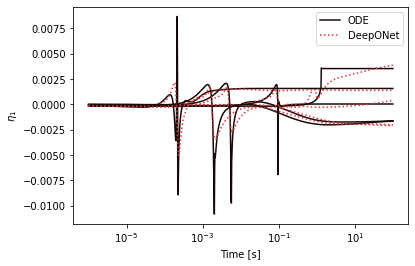

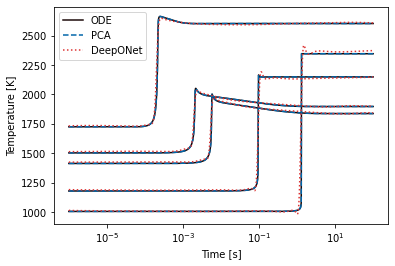

In [7]:
RedVar      = 'PC_15'
RedVar_Name = '$\eta_{1}$'

Var         = 'T'
Var_Name    = 'T'



ax   = []
fig  = []
fig1 = plt.figure()
fig.append(fig1)
ax.append(plt.axes())
fig2 = plt.figure()
fig.append(fig2)
ax.append(plt.axes())

# MSE   = 0.

jTest = 0
for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
    #####################################################################################################
    FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec0        = Data.to_numpy()[0,0]
    tVec         = Data.to_numpy()[:,0] - tVec0
    tVec[tVec == 0.] = FixedMinVal
    y_Data       = Data[input_vars]
    print('T = ', Data['T'].to_numpy()[0], 'K')
    

    #####################################################################################################
    if (PCA_NAME == 'All'):
        FileName         = DataDir+'/'+str(NVarsRed)+'PC/'+DataType+'/ext/PC.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)
        tVec             = Data.to_numpy()[:,0] - Data.to_numpy()[0,0]
        tVec[tVec == 0.] = FixedMinVal
        yPCA_Data        = Data[pca_vars]
        Data0            = Data[Data['t'] == 0.][pca_vars]
    if (scale == 'lin'):
        yPre_Data        = yPCA_Data[pca_vars_].to_numpy().dot(A)
        yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
    elif (scale == 'log'):
        yPre_Data        = yPCA_Data[pca_vars_].to_numpy().dot(A)
        yAnti_Data       = np.exp(yPre_Data * D[:,0] + C[:,0]) - 1.e-40
    elif (scale == 'log10'):
        yPre_Data        = yPCA_Data[pca_vars_].to_numpy().dot(A)
        yAnti_Data       = 10.**(yPre_Data * D[:,0] + C[:,0]) - 1.e-40
    yAnti_Data       = pd.DataFrame(yAnti_Data, columns=input_vars_)
    yAnti_Data       = pd.concat([yPCA_Data[pca_vars_not], yAnti_Data], axis=1)
    Data0            = pd.DataFrame([yPCA_Data.to_numpy()[0,:]], columns=pca_vars0)
    
    Data0            = Data0.loc[Data0.index.repeat(Nts)]
    Data0.columns    = pca_vars0
    Data0['T0']      = T0Vec
    Data0['t']       = tVec
    Data0['log10(t)']= np.log10(tVec)
    Data0['log(t)']  = np.log(tVec)
    Data0.reset_index(drop=True, inplace=True)
    

    if (jTest == 0):
        Label1 = 'ODE'
        Label2 = 'PCA'
        Label3 = 'DeepONet'
    else:
        Label1 = ''
        Label2 = ''
        Label3 = ''

    ax[0].plot(tVec+tVec0, yPCA_Data[RedVar],    '-', c=ColorVec[0], label=Label1)
    if (PCA_NAME == 'All'):
        ax[1].plot(tVec+tVec0, y_Data[Var],      '-', c=ColorVec[0], label=Label1)
        ax[1].plot(tVec+tVec0, yAnti_Data[Var], '--', c=ColorVec[2], label=Label2)

            
    yPCA_Pred  = pd.DataFrame(model.predict(Data0[InputVars]), columns=pca_vars)
    ax[0].plot(tVec+tVec0, yPCA_Pred[RedVar], ':', c=ColorVec[1], label=Label3)

#     if (jTest == 0):   
#         MSE  = (yPCA_Pred - yPCA_Data)**2
#     else:
#         MSE += (yPCA_Pred - yPCA_Data)**2

    if (PCA_NAME == 'All'):
        yPre_Pred  = yPCA_Pred[pca_vars_].dot(A)
        if (scale == 'lin'):
            yAnti_Pred = pd.DataFrame((yPre_Pred).to_numpy()*D[:,0] + C[:,0], columns=input_vars_)
        elif (scale == 'log'):
            yAnti_Pred = pd.DataFrame(np.exp( (yPre_Pred).to_numpy()*D[:,0] + C[:,0] ) - MinVal, columns=input_vars_)
        elif (scale == 'log10'):
            yAnti_Pred = pd.DataFrame(10.**( (yPre_Pred).to_numpy()*D[:,0] + C[:,0] ) - MinVal, columns=input_vars_)
        yAnti_Pred = pd.concat([yPCA_Pred[pca_vars_not], yAnti_Pred], axis=1)
        ax[1].plot(tVec+tVec0, yAnti_Pred[Var], ':', c=ColorVec[1], label=Label3)

        
    jTest += 1
    
ax[0].set_xscale('log')

ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel(r''+RedVar_Name+'')
#ax[0].set_xlim([1.e-8,1.e-2])
ax[0].legend()

if (PCA_NAME == 'All'):
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Time [s]')
    if (Var == 'T'):
        ax[1].set_ylabel('Temperature [K]')
    else:
        ax[1].set_ylabel(r''+Var_Name+', Mass Fraction')
    #ax[1].set_xlim([1.e-8,1.e-2])
    ax[1].legend()
    

    

if (FigDir):
    fig[0].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+RedVar+'.eps', format='eps', bbox_inches='tight')
    fig[1].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+Var+'.eps',    format='eps', bbox_inches='tight')

In [8]:
### EXPERIMENTING

# iPC      = 0

# VarOI    = 'H2'

# if (PCA_NAME == 'All'):
#     jPC = iPC
# else:
#     jPC = 0


# iVar     = VarNames.index(VarOI)
# iVarAnti = VarNamesAnti.index(VarOI)


# ax  = []

# fig = plt.figure(figsize=(16,12))
# ax.append(plt.axes())

# # fig = plt.figure(figsize=(16,12))
# # ax.append(plt.axes())

# for iTest in CasesVec:
#     Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
#     P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
#     EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
#     T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
#     #####################################################################################################
#     FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
#     Data         = pd.read_csv(FileName, header=0)
#     tVec         = Data.to_numpy()[:,0]
#     tVec[tVec == 0.] = FixedMinVal
#     y_Data       = Data[VarNames].to_numpy()
#     print('T = ', Data['T'].to_numpy()[0], 'K')
    

#     #####################################################################################################
#     if (PCA_NAME == 'All'):
#         FileName         = DataDir+'/'+str(NVarsRed)+'PC/'+DataType+'/ext/PC.csv.'+str(iTest+1)
#         Data             = pd.read_csv(FileName, header=0)
#         tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
#         yPCA_Data        = Data[Vars].to_numpy()
#         Data0            = Data[Data['t'] == 0.][Vars]
#     if (scale == 'lin'):
#         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
#     elif (scale == 'log'):
#         yPCA_Data        = ((np.log(y_Data[:,ToOrig_Mask] + MinVal) - C[:,0])/D[:,0]).dot(A.T)
#     yPre_Data            = yPCA_Data.dot(A)
#     yAnti_Data           = yPre_Data * D[:,0] + C[:,0]
#     Data0                = pd.DataFrame([yPCA_Data[0,:]], columns=Vars0)

#     ax[0].plot(tVec, yPCA_Data[:,iPC], '-k',  label='From ODE', lw=2)
# #     if (PCA_NAME == 'All'):
# #         ax[1].plot(tVec, y_Data[:,iVar],  '-k',  label='From ODE', lw=2)
# #         ax[1].plot(tVec, yAnti_Data[:,iVarAnti], '--g',  label='From PCA', lw=2)
        
#     NLoop                = 50
#     tLoop                = np.logspace(np.log10(tVec[10]), np.log10(tVec[-1]), NLoop)
#     DataLoop             = Data0.loc[Data0.index.repeat(NLoop)]#.drop([0])
#     DataLoop.columns     = Vars0
#     DataLoop['t']        = tLoop
#     DataLoop['log10(t)'] = np.log10(tLoop)
#     DataLoop['log(t)']   = np.log(tLoop)
#     DataLoop.reset_index(drop=True, inplace=True)

#     yMatLoop      = np.zeros((NLoop,NVarsRed))
#     InputPredLoop = np.concatenate([Data0.loc[0].to_numpy()[np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
#     yMatLoop[0,:] = model.predict(InputPredLoop)
#     for it, tLoop_ in enumerate(tLoop[1:]):
#         InputPredLoop    = np.concatenate([yMatLoop[it,:][np.newaxis,...], (tLoop[it+1]-tLoop[it])[np.newaxis,np.newaxis]], axis=1)
#         yMatLoop[it+1,:] = model.predict(InputPredLoop)

# #     Idxs                 = range(0,len(tVec),100)
# #     NLoop                = len(Idxs)
# #     tLoop                = np.zeros(NLoop)
# #     DataLoop             = Data0.loc[Data0.index.repeat(NLoop)]#.drop([0])
# #     DataLoop.columns     = Vars0
# #     DataLoop['t']        = tLoop
# #     DataLoop['log10(t)'] = np.log10(tLoop)
# #     DataLoop['log(t)']   = np.log(tLoop)
# #     DataLoop.reset_index(drop=True, inplace=True)

# #     yMatLoop      = np.zeros((NLoop,NVarsRed))
# #     yMatLoopExact = np.zeros((NLoop,NVarsRed))
# #     InputPredLoop = np.concatenate([yPCA_Data[Idxs[0],:][np.newaxis,...], (tVec[Idxs[0]])[np.newaxis,np.newaxis]], axis=1)
# #     tLoop[0]      = tVec[Idxs[0]]
# #     for it in range(NLoop-1):
# #         yMatLoopExact[it,:]  = yPCA_Data[Idxs[it],:]
# #         yMatLoop[it,:]       = model.predict(InputPredLoop)
# #         Deltat               = tVec[Idxs[it+1]]-tVec[Idxs[it]]
# #         tLoop[it+1]          = tLoop[it] + Deltat
# #         InputPredLoop        = np.concatenate([yPCA_Data[Idxs[it+1],:][np.newaxis,...], (Deltat)[np.newaxis,np.newaxis]], axis=1)
# #     yMatLoopExact[NLoop-1,:] = yPCA_Data[Idxs[NLoop-1],:]
# #     yMatLoop[NLoop-1,:]      = model.predict(InputPredLoop)
    
# #     ax[0].plot(tLoop, yMatLoopExact[:,iPC], ':ob')
#     ax[0].plot(tLoop, yMatLoop[:,iPC], ':or')

    
# ax[0].set_xscale('log')

# ax[0].set_xlabel('time [s]')
# ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
# #ax[0].set_xlim([1.e-8,1.e-2])
# #ax[0].legend()

# # if (PCA_NAME == 'All'):
# #     ax[1].set_xscale('log')
# #     ax[1].set_xlabel('time [s]')
# #     ax[1].set_ylabel(VarOI)
# #     #ax[1].set_xlim([1.e-8,1.e-2])
# #     #ax[1].legend()

### Checking Derivatives

In [9]:
# if (PCA_NAME == 'All'):
    
#     VarOI    = 'H2'

#     iVar     = VarNames.index(VarOI)
#     iVarAnti = VarNamesAnti.index(VarOI)


#     FileName      = DataDir + '/Orig/'+DataType+'/ext/ySource.csv.' + str(iTest+1)
#     DataSource    = pd.read_csv(FileName, header=0)
#     dydtAnti_Data = DataSource[VarNamesAnti].to_numpy()
#     dydtPre_Data  = dydtAnti_Data/D.T


#     ZeroDR  = rmnt.pinn.system.ZeroDR(InputData)

#     yPre_RealData      = (y_Data[:,ZeroDR.to_orig] - ZeroDR.C) / ZeroDR.D
#     dydtPre_RealData_f = ZeroDR.f(0., yPre_RealData, None)
#     dydtPre_RealData_n = np.gradient(yPre_RealData[:,iVarAnti], tVec) #* tVec[:,0]

#     dydtPre_Data_f     = ZeroDR.f(0., yPre_Data, None)
#     dydtPre_Data_n     = np.gradient(yPre_Data[:,iVarAnti], tVec) #* tVec[:,0]

#     dydtPre_Pred_f     = ZeroDR.f(0., yPre_Pred,  None)
#     dydtPre_Pred_n     = np.gradient(yPre_Pred[:,iVarAnti], tVec) #* tVec[:,0]

#     fig = plt.figure(figsize=(12,8))
#     plt.plot(tVec, dydtPre_Data[:,iVarAnti])
#     plt.plot(tVec, dydtPre_RealData_f[:,iVarAnti])
#     plt.plot(tVec, dydtPre_Data_f[:,iVarAnti])
#     plt.plot(tVec, dydtPre_Pred_f[:,iVarAnti])
#     plt.xscale('log')
#     # plt.xlim([1.e-14,1.e-13])
#     # plt.ylim([-1e9, 1e7])
#     plt.xlabel('Time [s]')
#     plt.ylabel(r'd('+VarOI+')/dt')

#     fig = plt.figure(figsize=(12,8))
#     #plt.plot(tVec, dydtPre_RealData_f[:,iVarAnti])
#     #plt.plot(tVec, dydtPre_RealData_n)
#     # plt.plot(tVec, dydtPre_Data_f[:,iVarAnti])
#     #plt.plot(tVec, dydtPre_Data_n)
#     plt.plot(tVec, dydtPre_Pred_f[:,iVarAnti])
#     #plt.plot(tVec, dydtPre_Pred_n)
#     plt.xscale('log')
#     # plt.xlim([1.e-14,1.e-13])
#     # plt.ylim([-1e9, 1e7])
#     plt.xlabel('Time [s]')
#     plt.ylabel(r'd('+VarOI+')/dt')

In [10]:
### EXPERIMENTING

# iPC = 6

# FileName       = DataDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
# Data           = pd.read_csv(FileName, header=0)
# tVec           = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
# yPCA_Data      = Data[Vars].to_numpy()

# FileName       = DataDir+'/'+str(NVarsRed)+'PC/train/ext/PCSource.csv.'+str(iTest+1)
# DataSource     = pd.read_csv(FileName, header=0)
# dPCdt_Data     = DataSource[SVars].to_numpy()

# dPCdt_Data_f   = ZeroDR.f_pc(0., yPCA_Data,  None)
# dPCdt_Data_n   = np.gradient(yPCA_Data[:,iPC], tVec) #* tVec[:,0]

# dPCdt_Pred_f   = ZeroDR.f_pc(0., yPCA_Pred,  None)
# dPCdt_Pred_n   = np.gradient(yPCA_Pred[:,iPC], tVec) #* tVec[:,0]



# fig = plt.figure(figsize=(12,8))

# #plt.plot(tVec, dPCdt_Data[:,iPC])

# #plt.plot(tVec, dPCdt_Data_f[:,iPC])
# #plt.plot(tVec, dPCdt_Data_n)

# plt.plot(tVec, dPCdt_Pred_f[:,iPC]/model.output_range[iPC])
# plt.plot(tVec, dPCdt_Pred_n/model.output_range[iPC])

# plt.xscale('log')
# # plt.xlim([1.e-14,1.e-13])
# # plt.ylim([-1e9, 1e7])

## Plotting Loss Histories

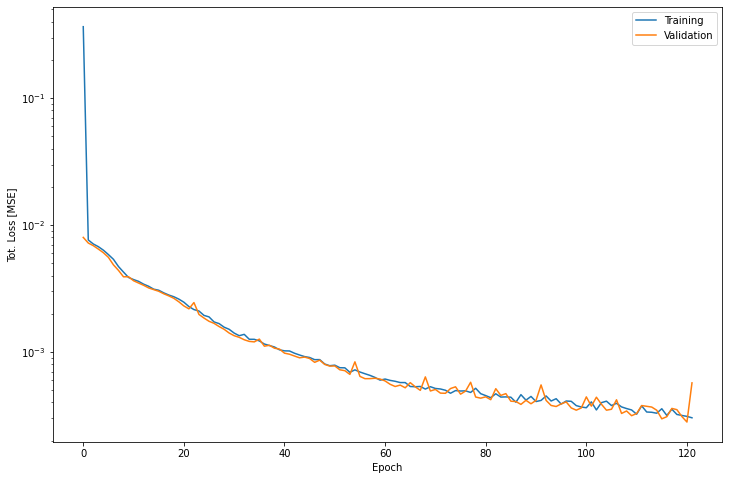

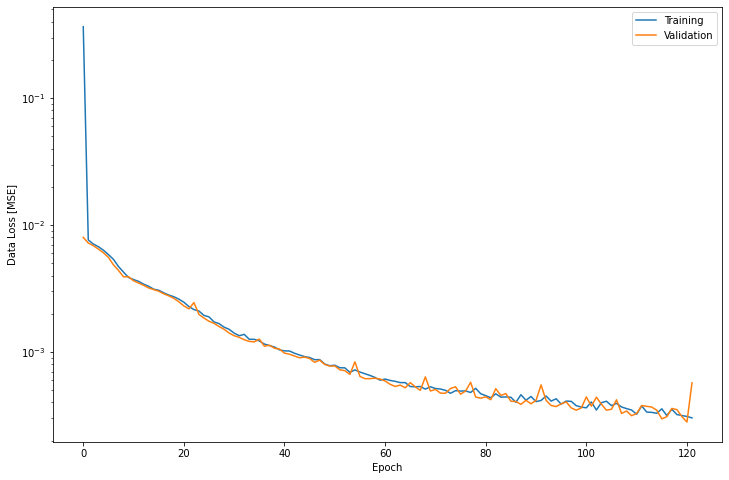

In [11]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [12]:
# fig = plt.figure(figsize=(12,8))
# plt.plot(tVec, yPCA_Data[:,iPC])
# plt.plot(tVec, yPCA_Pred[:,iPC])
# plt.xscale('log')
# # plt.xlim([1.e-14,1.e-13])
# # plt.ylim([-1e9, 1e7])

NameError: name 'iPC' is not defined

<Figure size 864x576 with 0 Axes>

In [ ]:
### EXPERIMENTING

# iPC = 0

# fig = plt.figure(figsize=(12,8))

# DataIn = pd.read_csv('/Users/sventur/Desktop/DAJE/Input.csv', header=None).to_numpy()
# plt.plot(DataIn[:,0], DataIn[:,iPC+1], 'o')

# plt.plot(tVec, yPCA_Pred[:,iPC])

# plt.xscale('log')

In [ ]:
# Data = pd.read_csv('/Users/sventur/Desktop/DAJE/Output.csv', header=None).to_numpy()

# dPCdt_Pred_f   = ZeroDR.f_pc(0., DataIn[:,1:],  None)
# #dPCdt_Pred_n   = np.gradient(DataIn[-1000:-1,iPC+1], DataIn[-1000:-1,0]) #* tVec[:,0]



# fig = plt.figure(figsize=(12,8))

# plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC+1],   'b+', markersize=4)
# #plt.plot(DataIn[-1000:-1,0], dPCdt_Pred_n/model.y_range[iPC], 'ro', markersize=1)

# plt.xscale('log')
# # plt.xlim([-5, -4])
# # plt.ylim([-1, -0.9])



# fig = plt.figure(figsize=(12,8))

# plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC+6], 'g+', markersize=8)
# plt.plot(DataIn[-1000:-1,0], dPCdt_Pred_f[-1000:-1,iPC]/model.y_range[iPC], 'ro', markersize=1)

# plt.xscale('log')
# # plt.xlim([-5, -4])
# # plt.ylim([-1, -0.9])

In [ ]:
### EXPERIMENTING

# Data    = pd.read_csv(DataDir+'/Orig/train/ext/ICs.csv')

# ICs      = np.zeros((5,2))
# ICs[:,0] = [2.5, 1.9, 3.5, 1., 3.6]
# ICs[:,1] = [1200., 1900., 1300., 1600., 1700.]

# plt.figure(figsize=(10,10))
# plt.plot(Data.EqRatio, Data['T'], 'o')
# plt.plot(ICs[:,0],ICs[:,1],'ro')
# plt.xlabel('Eq Ratio')
# plt.ylabel('T [K]')

## Evaluating Trunk's Outputs

In [ ]:
iTrunk           = 2
iTest            = 0

FileName         = DataDir+'/'+str(NVarsRed)+'PC/'+DataType+'/ext/PC.csv.'+str(iTest+1)
Data             = pd.read_csv(FileName, header=0)

fig = plt.figure()
plt.plot(Data['t'], Data['PC_'+str(iTrunk+1)])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\eta_{'+str(iTrunk+1)+'}$')



iVarVec = range(0,6,1)

tVecTot = np.logspace(-14,4,1000)

output_ = model.net.system_of_components['DeepONet'].components['Trunk_'+str(iTrunk+1)].call(tVecTot[...,np.newaxis], model.net.layers_dict, None, training=False)

fig = plt.figure()

for iVar in iVarVec:

    plt.plot(tVecTot, output_[:,iVar])

#plt.xlim([1.e-6, 1.e-2])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+str(iTrunk+1)+'_{i}}$')

## Evaluating Branches' Outputs

In [ ]:
# FileName     = DataDir + '/Orig/train/ext/SimIdxs.csv'
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)


# FileName     = DataDir + '/Orig/train/ext/ICs.csv'
# Data         = pd.read_csv(FileName)
# ICVecs       = Data.to_numpy()
# n_ics        = len(ICVecs)
n_ics         = 500

Cols   = []
NewFlg = True
for iC in range(n_ics):

    try:
        FileName             = DataDir+'/'+str(NVarsRed)+'PC/'+DataType+'/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)

        DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]

        if (NewFlg):
            DataIC           = DataICTemp
            NewFlg           = False
        else:
            DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))
            
    except:
        pass

tVec              = Data['t']
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

DataIC.head()

In [ ]:
iBranch = 0
iVar    = 5



output_ = model.net.system_of_components['DeepONet'].components['Branch_'+str(iBranch+1)].call(DataIC.to_numpy(), model.net.layers_dict, None, training=False)



#%matplotlib qt

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iVar], c='r')
ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

## Evaluating Rigid Block + Trunk's Outputs

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


output_ = model.net.system_of_components['DeepONet'].components['Stretch'].call(DataIC.to_numpy(), model.net.layers_dict, None, training=False)
output_ = np.log(1. + np.exp(output_))

for iBranch in range(7):
    #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
    ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$j='+str(iBranch+1)+'$')

ax.set_xlabel('\n'+r'$\eta_{1_0}$', rotation = 0)
ax.set_ylabel(r'           $\eta_{2_0}$', rotation = 0)
ax.set_zlabel(r'         $\log(\bar{t}_j)$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.legend()
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput.eps', format='eps', bbox_inches='tight')

In [ ]:
# fig = plt.figure(figsize=(10,10))
# ax  = fig.add_subplot(projection='3d')


# output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), training=False)

# output_.shape

# for iBranch in range(7,14):
#     #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
#     ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$\eta_{'+str(iBranch+1)+'}$')


# ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
# ax.set_zlabel(r'$\log(\bar{t})$')
# ax.legend()
# #ax.set_zscale('log')

In [ ]:
iPCVec   = [0,1]

for iPC in iPCVec:

    NewFlg   = True
    fig, ax1 = plt.subplots()
    ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    for iTest in CasesVec:
        
        FileName         = DataDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        yPCA_Data        = Data[Vars].to_numpy()
        Data0            = Data[Data['t'] == 0.][Vars]
#         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
#         yPre_Data        = yPCA_Data.dot(A)
#         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
#         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

        if NewFlg:
            Label1 = 'ODE'
            Label2 = 'Rigid Block Prepr.'
            NewFlg = False
        else:
            Label1 = None
            Label2 = None

    
        ax1.plot(np.log(tVec), yPCA_Data[:,iPC], color=ColorVec[0], label=Label1)

        ax2.plot(np.log((tVec)*output_[iTest,iPC]), yPCA_Data[:,iPC], color=ColorVec[1], label=Label2)

    #plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])
    
    color = ColorVec[0]
    ax1.set_xlabel(r'$\log(t)$', size=34)
    ax1.set_ylabel(r'$\eta_'+str(iPC+1)+'$', color=color, size=34)
    ax1.tick_params(axis='y', labelcolor=color)

    color = ColorVec[1]
    ax2.set_xlabel(r'$\log(t)-\log(\bar{t_{'+str(iPC+1)+'}})$', color=color, size=34)  # we already handled the x-label with ax1
    #ax2.set_ylabel(r'$x$', color=color, size=34)
    ax2.tick_params(axis='x', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.legend(loc=4)
    
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_test_DeepONet_Eta'+str(iPC+1)+'_Shift.eps', format='eps', bbox_inches='tight')